# Function Calling <br>

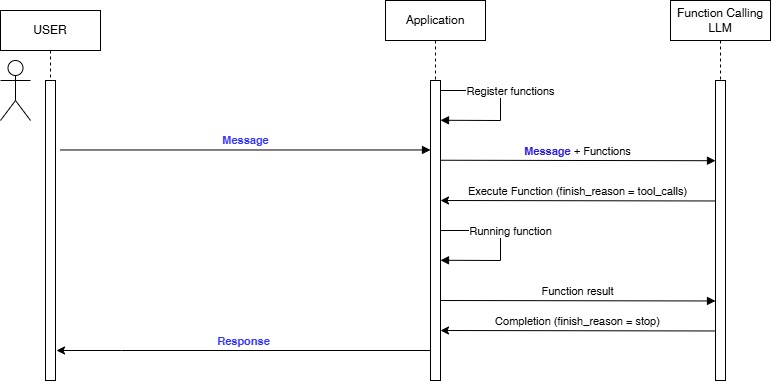

# Librerias


In [1]:
import os
import json
import requests 
from dotenv import load_dotenv
from openai import AzureOpenAI

# Carga de variables de .env

In [ ]:
load_dotenv(override=True)

az_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT_URL")
az_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
az_openai_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

bing_api_key = os.getenv("BING_API_KEY")

az_openai_deployment_name

# Crea el cliente Azure OpenAI

In [3]:
# Initialize the Azure OpenAI client
az_openai_client = AzureOpenAI(
    azure_endpoint=az_openai_endpoint,
    api_key=az_openai_api_key,
    api_version="2024-05-01-preview",
)

messages = []

# Funciones de ayuda

In [4]:
# Message storage
def store_message_in_list(message_list, message_role, **kwargs):
    # Create the base message with the required role
    message = {"role": message_role}
    
    # Dynamically add additional fields from kwargs
    message.update(kwargs)
    # Append the message to the list
    message_list.append(message)

# Azure OpenAI API Calls
def call_azure_openai(az_openai_client, az_openai_deployment_name, messages):
    # Build the parameters dynamically
    params = {
        "model": az_openai_deployment_name,
        "messages": messages
    }
    # Call the Azure OpenAI API
    response = az_openai_client.chat.completions.create(**params)
    return response

def send_user_input_to_az_openai(user_input, az_openai_client=az_openai_client, az_openai_deployment_name=az_openai_deployment_name, messages=messages):
    # Store user message
    store_message_in_list(messages, "user", content=user_input)
    # Query AzOpenAI
    az_openai_response = call_azure_openai(az_openai_client, az_openai_deployment_name, messages)
    
    return az_openai_response.choices[0]

# Initializa mensajes

In [ ]:
SYSTEM_MESSAGE = "Eres un asistente que ayuda"

store_message_in_list(messages, "system", content=SYSTEM_MESSAGE)
messages

# Comprobamos fecha de cut-off del modelo

In [ ]:
user_input = "Hasta que fecha has aprendido?"
model_response = send_user_input_to_az_openai(user_input)

model_response

In [ ]:
post_cutoff_question = "quien gano la EURO 2024?"
model_response = send_user_input_to_az_openai(post_cutoff_question)

model_response.message.content

# Añadimos Tools - Busqueda en Bing

In [8]:
def search_for_data_in_bing(query):
    """Search the Bing Web Search API and return the first result."""
    headers = {
        "Ocp-Apim-Subscription-Key": bing_api_key
    }
    params = {
        "q": query,
        "count": 1  # Only request 1 result
    }

    response = requests.get("https://api.bing.microsoft.com/v7.0/search", headers=headers, params=params)
    response.raise_for_status()
    data = response.json()

    if "webPages" in data and "value" in data["webPages"] and len(data["webPages"]["value"]) > 0:
        first_result = data["webPages"]["value"][0]
        snippet = first_result.get("snippet", "No Snippet")
        return snippet
    else:
        return "No results found."

## Probamos la tool

In [ ]:
search_for_data_in_bing("Capital de Estados Unidos")

## Registro de tools para llamada a Azure OpenAI

In [10]:
tool_map = {
    "search_for_data_in_bing": search_for_data_in_bing
}

tools = [
    {
        "type": "function",
        "function": {
            "name": "search_for_data_in_bing",
            "description": "Search for data on the internet for a given topic",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The content to search for"
                    },
                },
                "required": ["query"],
            },
        }
    }
]

## Llamada a API con tools

In [11]:
def call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages, tools=tools, tool_choice="auto"):
    # Build the parameters dynamically
    params = {
        "model": az_openai_deployment_name,
        "messages": messages,
        "tools": tools,
        "tool_choice": tool_choice
    }

    # Call the Azure OpenAI API
    response = az_openai_client.chat.completions.create(**params)
    return response.choices[0]

def send_user_input_to_az_openai_with_tools(
    user_input,
    az_openai_client = az_openai_client,
    az_openai_deployment_name = az_openai_deployment_name,
    messages = messages,
    tools = tools,
    tool_choice = "auto"
):
    # Store user message
    store_message_in_list(messages, "user", content=user_input)
    # Query AzOpenAI
    az_openai_response = call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages,  tools, tool_choice)

    az_openai_response
    
    return az_openai_response

In [ ]:
post_cutoff_question = "quien gano la EURO 2024?"
model_response = send_user_input_to_az_openai_with_tools(post_cutoff_question )

model_response

## La respuesta del modelo indica que hay que ejecutar una tool
finish_reason no es stop. Nos indica que hay una tool_call pendiente

In [ ]:
tool_call = model_response.message.tool_calls[0].function

tool_call

## Almacenamos la respuesta en lista de mensajes

In [14]:
store_message_in_list(
    messages,
    "assistant",
    function_call=tool_call
)

## Obtenemos parametros y nombre de la funcion

In [15]:
function_name = tool_call.name
function_args = json.loads(tool_call.arguments)

## Llamamos a la funcion

In [ ]:
function_call_result = tool_map[function_name](**function_args)
function_call_result

## Guardamos el resultado en la lista de mensajes

In [17]:
store_message_in_list(
    messages,
    "function",
    content=function_call_result,
    name=function_name
)

In [ ]:
messages

## Llamamos al LLM con el resultado de la tool

In [ ]:
response = call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages, tools)
response.message.content

## Gracias al uso de tools, sabemos el resultado!